In [2]:
from constants import API_KEY, STEAM64_ID, ACCOUNT_ID

In [3]:
import requests
import time
from datetime import datetime, timezone


def fetch_all_matches(account_id, api_key, steam_id, all_matches, match_sequence_numbers, match_start_times, match_hero_ids, matches_requested=25, sleep_time=1):
    url = "https://api.steampowered.com/IDOTA2Match_570/GetMatchHistory/v1/"
    
    seen_match_ids = set()  # To track unique matches
    start_at_match_id = None

    while True:
        params = {
            "key": api_key,
            "account_id": steam_id,
            "matches_requested": matches_requested
        }
        if start_at_match_id:
            params["start_at_match_id"] = start_at_match_id

        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            break

        data = response.json().get("result", {})
        matches = data.get("matches", [])

        if not matches:
            print("No more matches to fetch.")
            break

        # Add new matches, avoiding duplicates
        for match in matches:
            if match["match_id"] not in seen_match_ids:
                all_matches.append(match)
                match_sequence_numbers.append(match["match_seq_num"])
                match_start_times.append(match["start_time"]) #storing match start time info as it is
                seen_match_ids.add(match["match_id"])
                
                players = match.get("players", [])
                for player in players:
                    if player.get("account_id") == account_id:
                        print(player.get("account_id"))
                        match_hero_ids[match["match_seq_num"]] = player.get("hero_id")
                

        # Update pagination
        start_at_match_id = matches[-1]["match_id"] - 1  # Adjust to avoid duplication
        print(f"Fetched {len(matches)} matches. Total so far: {len(all_matches)}")

        # Stop fetching if we've reached the total results
        if len(all_matches) >= data.get("total_results", 0):
            print("All matches fetched.")
            break

        # Sleep to avoid exceeding rate limits
        time.sleep(sleep_time)

    return 

all_matches = []
match_sequence_numbers = []
match_start_times = []
match_hero_ids = {}

fetch_all_matches(ACCOUNT_ID, API_KEY, str(STEAM64_ID), all_matches, match_sequence_numbers, match_start_times, match_hero_ids)
print(f"Total matches fetched: {len(all_matches)}")


845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
Fetched 25 matches. Total so far: 25
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
Fetched 25 matches. Total so far: 50
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
Fetched 25 matches. Total so far: 75
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026
845436026

In [4]:

hero_id_counts = {}
for hero_id in match_hero_ids.values():
    if hero_id not in hero_id_counts.keys():
        hero_id_counts[hero_id] = 1
    else:
        hero_id_counts[hero_id] += 1 

for hero_id in hero_id_counts.keys():
    print(hero_id, "    ", hero_id_counts[hero_id])

61      3
31      1
4      17
14      2
29      1
55      2
81      14
30      7
18      7
54      13
2      6
49      6
59      26
74      16
99      7
94      1
95      22
101      15
10      8
105      1
63      8
33      2
109      10
91      10
44      1
64      14
70      3
34      1
129      2
119      2
60      3
15      1
12      2
5      3
22      6
85      1
35      8
39      17
47      9
108      1
28      3
62      1
9      1
8      2
93      1
11      1
26      3
71      1
121      1
32      1
6      10
17      1
128      2
23      1
41      2
102      1
75      1
19      6
42      10
56      1
48      3
21      1
66      1
27      1


# Here we can see heroes with match count bigger than 5. This is usefull to detect patterns within hero performance and match count.

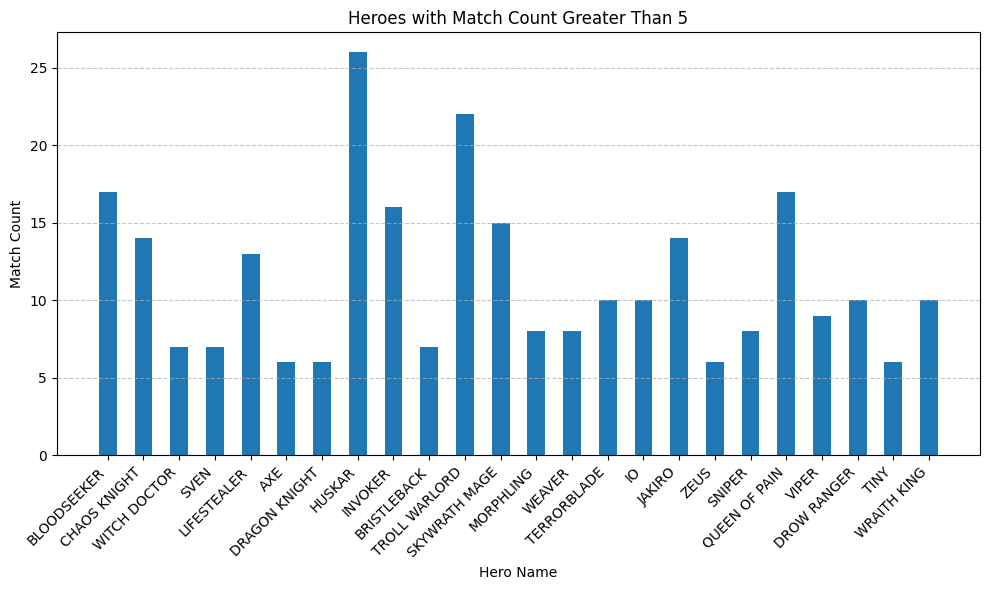

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load heroes_info.csv (replace 'heroes_info.csv' with the actual path to your file)
heroes_info_path = 'data/heroes_info.csv'
heroes_info = pd.read_csv(heroes_info_path)

# Create a mapping from Hero ID to Hero Name
hero_id_to_name = dict(zip(heroes_info['Hero ID'], heroes_info['Name']))
filtered_hero_counts = {hero_id: count for hero_id, count in hero_id_counts.items() if count > 5}


# Map hero_ids to hero names for visualization
filtered_hero_names_counts = {
    hero_id_to_name[hero_id]: count
    for hero_id, count in filtered_hero_counts.items()
    if hero_id in hero_id_to_name
}

# Visualize filtered heroes with names as x-axis
plt.figure(figsize=(10, 6))
plt.bar(filtered_hero_names_counts.keys(), filtered_hero_names_counts.values(), width=0.5)
plt.xlabel("Hero Name")
plt.ylabel("Match Count")
plt.title("Heroes with Match Count Greater Than 5")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [13]:
import requests
import json
import os
import time

# Constants
BASE_URL = "https://api.steampowered.com/IDOTA2Match_570/GetMatchHistoryBySequenceNum/v1"
RAW_DATA_DIR = os.path.join("data/raw_data/my_matches_json")  # Directory to store JSON files
BATCH_SIZE = 100          # Matches per request
MATCHES_PER_FILE = 200     # Matches per JSON file

# Ensure raw_data directory exists
os.makedirs(RAW_DATA_DIR, exist_ok=True)

def fetch_match_by_sequence(sequence_num, api_key):
    """Fetch match data for a specific sequence number."""
    params = {
        "key": api_key,
        "start_at_match_seq_num": sequence_num,
        "matches_requested": 1  # Fetch one match
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching match {sequence_num}: {response.status_code}")
        return None

def save_batch_to_file(data_batch, file_index):
    """Save a batch of match data to a single JSON file."""
    file_name = os.path.join(RAW_DATA_DIR, f"my_matches_batch_{file_index}.json")
    with open(file_name, 'w') as f:
        json.dump(data_batch, f, indent=4)
    print(f"Saved {len(data_batch)} matches to {file_name}")

def main():
    current_batch = []
    file_index = 1

    for i, seq_num in enumerate(match_sequence_numbers):
        print(f"Fetching match for sequence number: {seq_num}")
        match_data = fetch_match_by_sequence(seq_num, API_KEY)
        
        if match_data and "result" in match_data and "matches" in match_data["result"]:
            current_batch.append(match_data["result"]["matches"][0])

        # Save the batch if it reaches the limit
        if len(current_batch) >= MATCHES_PER_FILE:
            save_batch_to_file(current_batch, file_index)
            current_batch = []  # Reset the batch
            file_index += 1
        
        time.sleep(0.3)

    # Save any remaining matches
    if current_batch:
        save_batch_to_file(current_batch, file_index)

if __name__ == "__main__":
    main()

Fetching match for sequence number: 6803707269
Fetching match for sequence number: 6803219777
Fetching match for sequence number: 6803124865
Fetching match for sequence number: 6803065802
Fetching match for sequence number: 6803018429
Fetching match for sequence number: 6801404603
Fetching match for sequence number: 6801386701
Fetching match for sequence number: 6794200794
Fetching match for sequence number: 6793941569
Fetching match for sequence number: 6793878034
Fetching match for sequence number: 6793836309
Fetching match for sequence number: 6793234081
Fetching match for sequence number: 6792147679
Fetching match for sequence number: 6789945976
Fetching match for sequence number: 6789913358
Fetching match for sequence number: 6787236269
Fetching match for sequence number: 6787207859
Fetching match for sequence number: 6787186453
Fetching match for sequence number: 6787151056
Fetching match for sequence number: 6787084387
Fetching match for sequence number: 6785909782
Fetching matc

## IMPORTANT
- Second API endpoint contains detailed information about the match but it's not possible to detect which hero I played from that json response since it contains all heroes in the match. That's why I collect hero_id, match_sequence_number pairs in a csv file in order to find out which hero I played in later the stage of the project.

In [8]:
import csv

def save_hero_matches_to_csv(hero_matches, csv_file):
    """
    Save the dictionary of heroes played in a match to a CSV file.
    
    Parameters:
    - hero_matches: dict, where keys are sequence numbers and values are hero IDs
    - csv_file: str, the path to the CSV file to write
    """
    # Open the CSV file for writing
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(["seq_num", "hero_id"])
        
        # Write the data
        for seq_num, hero_id in hero_matches.items():
            writer.writerow([seq_num, hero_id])
    
    print(f"Data successfully saved to {csv_file}")


csv_file_path = "data/parsed_data/my_matches_hero_id.csv"
save_hero_matches_to_csv(match_hero_ids, csv_file_path)


Data successfully saved to data/parsed_data/my_matches_hero_id.csv
